In [ ]:
#This notebook was developed based on the experiments and code done by 
##Author: Amgad Shalaby
##Contact: https://www.linkedin.com/in/amgad-shalaby-711287228/
##Published on: https://www.kaggle.com/

In [ ]:
#!sudo apt-get install libgl1 -y

In [5]:
%pip install efficientnet

  Using cached efficientnet-1.1.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl.metadata (1.7 kB)
Using cached efficientnet-1.1.1-py3-none-any.whl (18 kB)
Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#%pip install opencv-python

In [16]:
import os 
from os import listdir
from os.path import join, isfile

In [17]:
from glob import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import efficientnet.tfkeras as efn

In [88]:
image_size = 224
batch_size = 64
epochs = 30

In [ ]:
#used limit number of data and classification types for test purpose
local_train = '/home/sagemaker-user/local/data/train/'
local_val = '/home/sagemaker-user/local/data/val/'

In [90]:
files = listdir(local_train)
files = [f.lower() for f in files]
sorted(files)

['tomato___early_blight', 'tomato___healthy', 'tomato___late_blight']

In [91]:
label =files
NUM_CLASS=len(label)

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

In [93]:
train_generator = train_gen.flow_from_directory(
    directory=local_train,
    target_size=(image_size, image_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 507 images belonging to 3 classes.


In [94]:
valid_generator = val_gen.flow_from_directory(
    directory=local_val,
    target_size=(image_size, image_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

Found 460 images belonging to 3 classes.


In [95]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(image_size,image_size, 3))
conv_base.trainable=False

In [96]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

In [97]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(negative_slope=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [98]:
#### metrics
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)    │ (None, 7, 7, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,740,447 (18.08 MB)

 Trainable params: 3,846,623 (14.67 MB)

 Non-trainable params: 893,824 (3.41 MB)

In [ ]:
#| Layer                        | Description                                                                                                                                                                                                                                                   |
#| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
#| `efficientnet-b0`            | This is the **pre-trained base model** (EfficientNetB0), used here as a **feature extractor**. It outputs feature maps of shape **(7, 7, 1280)**. It contains **4,049,564 parameters**, of which a portion may be **frozen** (non-trainable) during training. |
#| `global_average_pooling2d_3` | This layer reduces the spatial dimensions (7×7) to a single vector of length 1280 by computing the **average** of each feature map. It has **no parameters**.                                                                                                 |
#| `dropout_6`                  | A **Dropout** layer that randomly disables a fraction of neurons (usually during training) to prevent overfitting. It has **no trainable parameters**.                                                                                                        |
#| `dense_13`                   | A **Dense** layer with 64 units. Further transforms the representation. It has **32,832 parameters**.                                                                                                                                                         |
#| `dropout_7`                  | Another **Dropout** layer for regularization. Again, **no parameters**.                                                                                                                                                                                       |
#| `dense_14`                   | A **Dense** layer with 32 units. Used to reduce the feature dimensionality. Has **2,080 parameters**.                                                                                                                                                         |
#| `dense_15`                   | Final **Dense** output layer with 3 units, corresponding to **3 output classes**. This is likely followed by a **Softmax** activation (not shown here) for multi-class classification. It has **99 parameters**.                                              |


| Type                         | Count         | Size       |
| ---------------------------- | ------------- | ---------- |
| **Total Parameters**         | **4,740,447** | \~18.08 MB |
| **Trainable Parameters**     | **3,846,623** | \~14.67 MB |
| **Non-trainable Parameters** | **893,824**   | \~3.41 MB  |


In [99]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=15),
    ModelCheckpoint('best_note_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    Precision(), 
    Recall()
]

In [100]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
# Train the neural network model and store training history for future model analysis 
history = model.fit(train_generator,epochs=epochs, batch_size=batch_size, validation_data=valid_generator,callbacks= callbacks)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.5392 - loss: 0.9631 - precision_3: 0.6756 - recall_3: 0.1918

8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 12s/step - categorical_accuracy: 0.5544 - loss: 0.9419 - precision_3: 0.6956 - recall_3: 0.2158 - val_categorical_accuracy: 0.6848 - val_loss: 0.6974 - val_precision_3: 0.7191 - val_recall_3: 0.6457 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - categorical_accuracy: 0.9081 - loss: 0.2384 - precision_3: 0.9138 - recall_3: 0.8986 - val_categorical_accuracy: 0.7978 - val_loss: 0.7654 - val_precision_3: 0.7991 - val_recall_3: 0.7957 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 89s 12s/step - categorical_accuracy: 0.9820 - loss: 0.0749 - precision_3: 0.9820 - recall_3: 0.9820 - val_categorical_accuracy: 0.7435 - val_loss: 2.1294 - val_precision_3: 0.7467 - val_recall_3: 0.7435 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 12s/step - categorical_accuracy: 0.9577 - loss: 0.1218 - precision_3: 0.9583 - recall_3: 0.9570 - val_categorical_accuracy: 0.6783 - val_loss: 4.0702 - val_precision_3: 0.6812 - val

8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 11s/step - categorical_accuracy: 0.9831 - loss: 0.0423 - precision_3: 0.9831 - recall_3: 0.9831 - val_categorical_accuracy: 0.9217 - val_loss: 0.5448 - val_precision_3: 0.9216 - val_recall_3: 0.9196 - learning_rate: 0.0010
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.9972 - loss: 0.0186 - precision_3: 0.9972 - recall_3: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 144s 12s/step - categorical_accuracy: 0.9967 - loss: 0.0195 - precision_3: 0.9967 - recall_3: 0.9917 - val_categorical_accuracy: 0.9217 - val_loss: 0.4737 - val_precision_3: 0.9217 - val_recall_3: 0.9217 - learning_rate: 0.0010
Epoch 13/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - categorical_accuracy: 0.9955 - loss: 0.0157 - precision_3: 0.9955 - recall_3: 0.9955 - val_categorical_accuracy: 0.9413 - val_loss: 0.5143 - val_precision_3: 0.9434 - val_recall_3: 0.9413 - learning_rate: 0.0010
Epoch 14/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - categorical_accuracy: 0.9940 - loss: 0.0177 - precision_3: 0.9940 - recall_3: 0.9940 - val_categorical_accuracy: 0.9370 - val_loss: 0.5234 - val_precision_3: 0.9370 - val_recall_3: 0.9370 - learning_rate: 0.0010
Epoch 15/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 12s/step - categorical_accuracy: 0.9918 - loss: 0.0197 - precision_3: 0.9918 - recall_3: 0.9918 - val_categorical_accuracy: 0.9000 - val_loss: 0.6309 - val_precision_3: 0.8998 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - categorical_accuracy: 0.9982 - loss: 0.0068 - precision_3: 1.0000 - recall_3: 0.9982 - val_categorical_accuracy: 0.9457 - val_loss: 0.4500 - val_precision_3: 0.9477 - val_recall_3: 0.9457 - learning_rate: 0.0010
Epoch 22/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.9987 - loss: 0.0078 - precision_3: 0.9987 - recall_3: 0.9987

8/8 ━━━━━━━━━━━━━━━━━━━━ 90s 12s/step - categorical_accuracy: 0.9987 - loss: 0.0081 - precision_3: 0.9987 - recall_3: 0.9987 - val_categorical_accuracy: 0.9522 - val_loss: 0.4138 - val_precision_3: 0.9521 - val_recall_3: 0.9500 - learning_rate: 0.0010
Epoch 23/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 1.0000 - loss: 0.0024 - precision_3: 1.0000 - recall_3: 1.0000

8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - categorical_accuracy: 1.0000 - loss: 0.0024 - precision_3: 1.0000 - recall_3: 1.0000 - val_categorical_accuracy: 0.9565 - val_loss: 0.3998 - val_precision_3: 0.9564 - val_recall_3: 0.9543 - learning_rate: 0.0010
Epoch 24/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.9953 - loss: 0.0130 - precision_3: 0.9953 - recall_3: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 11s/step - categorical_accuracy: 0.9954 - loss: 0.0134 - precision_3: 0.9954 - recall_3: 0.9954 - val_categorical_accuracy: 0.9565 - val_loss: 0.3734 - val_precision_3: 0.9565 - val_recall_3: 0.9565 - learning_rate: 0.0010
Epoch 25/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.9998 - loss: 0.0049 - precision_3: 0.9998 - recall_3: 0.9998

8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 11s/step - categorical_accuracy: 0.9996 - loss: 0.0053 - precision_3: 0.9996 - recall_3: 0.9996 - val_categorical_accuracy: 0.9587 - val_loss: 0.3470 - val_precision_3: 0.9587 - val_recall_3: 0.9587 - learning_rate: 0.0010
Epoch 26/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.9923 - loss: 0.0190 - precision_3: 0.9923 - recall_3: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 90s 12s/step - categorical_accuracy: 0.9920 - loss: 0.0195 - precision_3: 0.9920 - recall_3: 0.9920 - val_categorical_accuracy: 0.9543 - val_loss: 0.3194 - val_precision_3: 0.9543 - val_recall_3: 0.9543 - learning_rate: 0.0010
Epoch 27/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - categorical_accuracy: 0.9950 - loss: 0.0153 - precision_3: 0.9950 - recall_3: 0.9950 - val_categorical_accuracy: 0.9304 - val_loss: 0.3953 - val_precision_3: 0.9304 - val_recall_3: 0.9304 - learning_rate: 0.0010
Epoch 28/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 11s/step - categorical_accuracy: 0.9827 - loss: 0.0257 - precision_3: 0.9827 - recall_3: 0.9827 - val_categorical_accuracy: 0.9652 - val_loss: 0.3938 - val_precision_3: 0.9652 - val_recall_3: 0.9652 - learning_rate: 0.0010
Epoch 29/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 87s 11s/step - categorical_accuracy: 0.9980 - loss: 0.0146 - precision_3: 0.9980 - recall_3: 0.9980 - val_categorical_accuracy: 0.9652 - val_loss: 0.4234 - val_precision_3: 0.9652 - v

In [ ]:
df = pd.DataFrame(history.history)
df.head()

,categorical_accuracy,loss,precision_3,recall_3,val_categorical_accuracy,val_loss,val_precision_3,val_recall_3,learning_rate
0,0.676529,0.772531,0.855372,0.408284,0.684783,0.697422,0.719128,0.645652,0.001
1,0.936884,0.195338,0.940239,0.930966,0.797826,0.765381,0.799127,0.795652,0.001
2,0.972387,0.103396,0.972387,0.972387,0.743478,2.129435,0.746725,0.743478,0.001
3,0.954635,0.132431,0.956436,0.952663,0.678261,4.070229,0.681223,0.678261,0.001
4,0.968442,0.074996,0.968442,0.968442,0.721739,3.343461,0.724891,0.721739,0.001


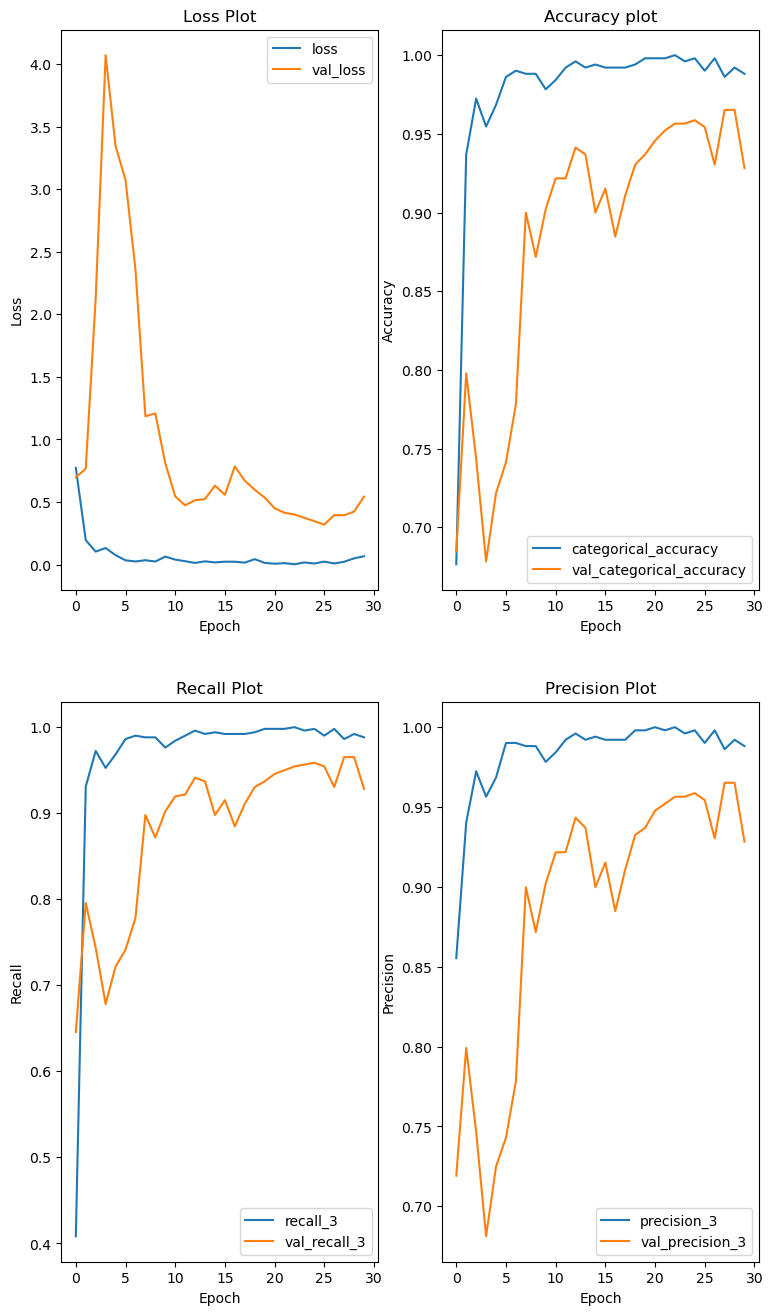

In [ ]:
# Creates a visualization of metrics from a machine learning model's training process
# The figure size is set to 9 inches wide and 16 inches tall
fig, ax = plt.subplots(figsize=(9,16), nrows=2,ncols=2)
df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
df[['categorical_accuracy','val_categorical_accuracy']].plot(ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
df[['precision_3','val_precision_3']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
df[['recall_3','val_recall_3']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [ ]:
model.save('note_model.h5')